In [1]:
pip install tensorflow


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# Load content and style images
def load_img(path_to_img):
    max_dim = 256
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)


# Load a VGG19 model pre-trained on ImageNet data
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Choose intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Build the model
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Create the model
style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

# Style and content model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

extractor = StyleContentModel(style_layers, content_layers)

# Run gradient descent
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_min=0.0, clip_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1
num_style_layers=5
content_weight=3
num_content_layers=4
# Perform optimization
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Update the image with style
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(imshow(image.read_value()))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Display the stylized image
imshow(image, 'Stylized Image')


TypeError: ignored

None

Train step: 1000
Total time: 22.9


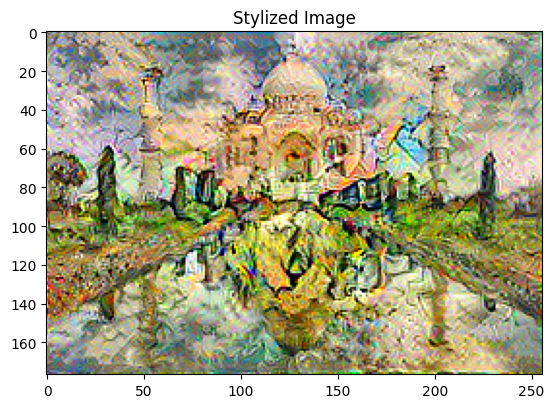

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display



# Load content and style images
def load_img(path_to_img):
    max_dim = 256
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

content_image = load_img('/content/taj_mahal.jpg')
style_image = load_img('/content/vg_houses.jpg')
# Update these paths with your images' paths
# Load a VGG19 model pre-trained on ImageNet data
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Choose intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Build the model
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Create the model
style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

# Style and content model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

extractor = StyleContentModel(style_layers, content_layers)

# Define weights for style and content loss
style_weight=0.001
content_weight=1000

# Run gradient descent
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Perform optimization
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    print(loss)
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Update the image with style
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(imshow(image.read_value()))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Display the stylized image
imshow(image, 'Stylized Image')


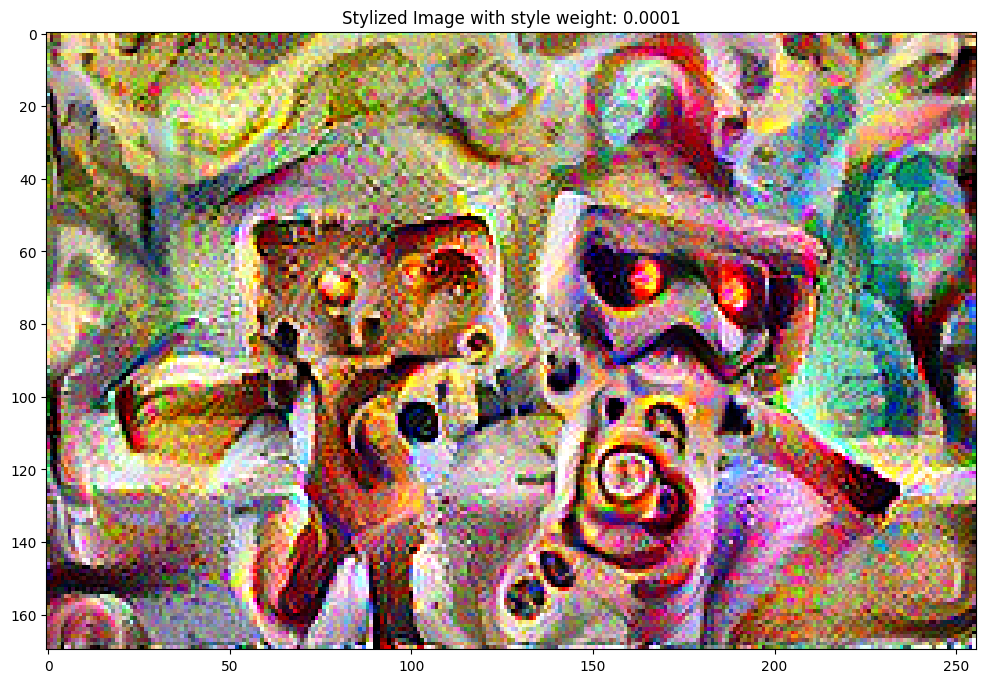

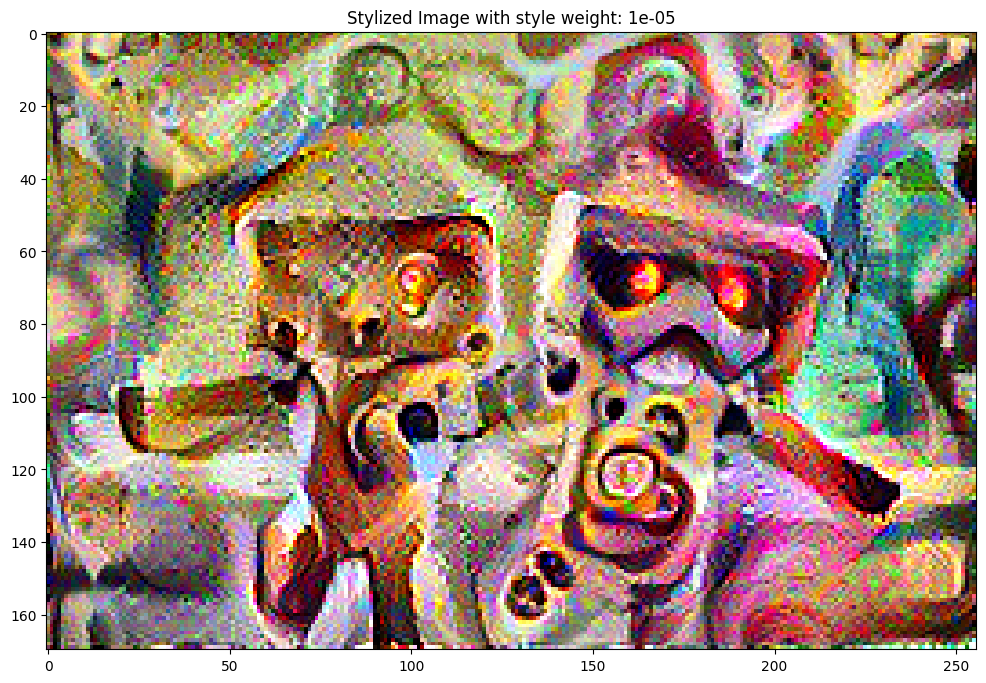

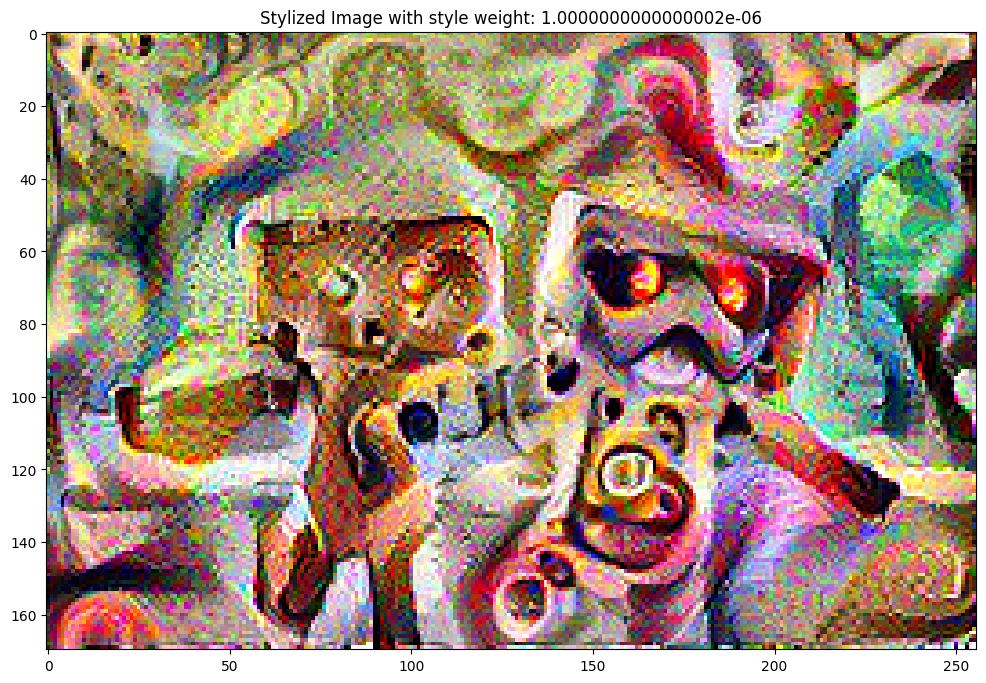

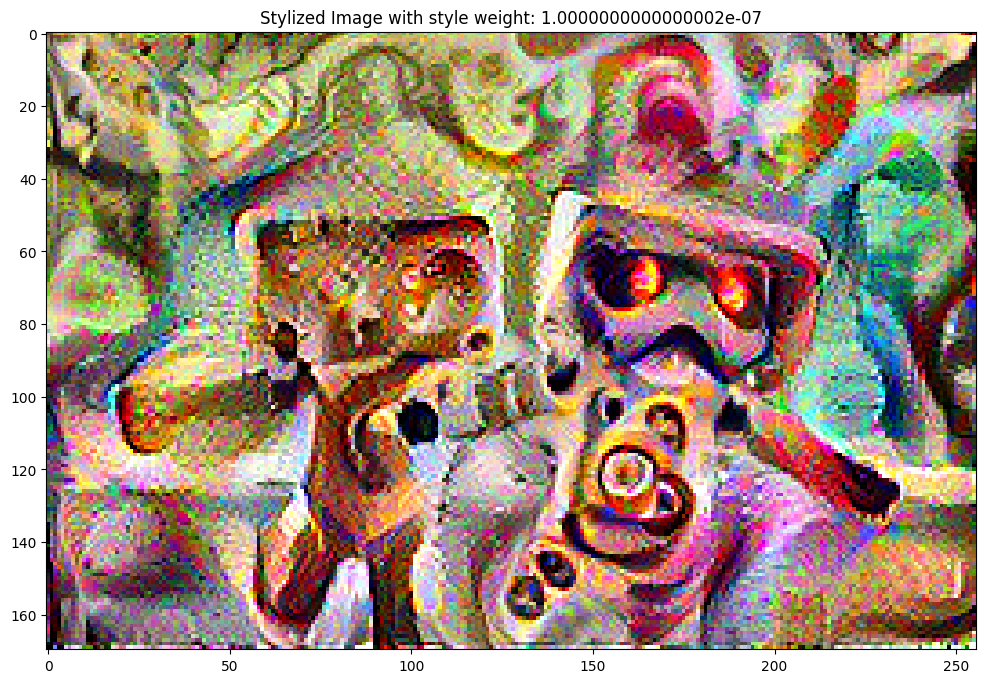

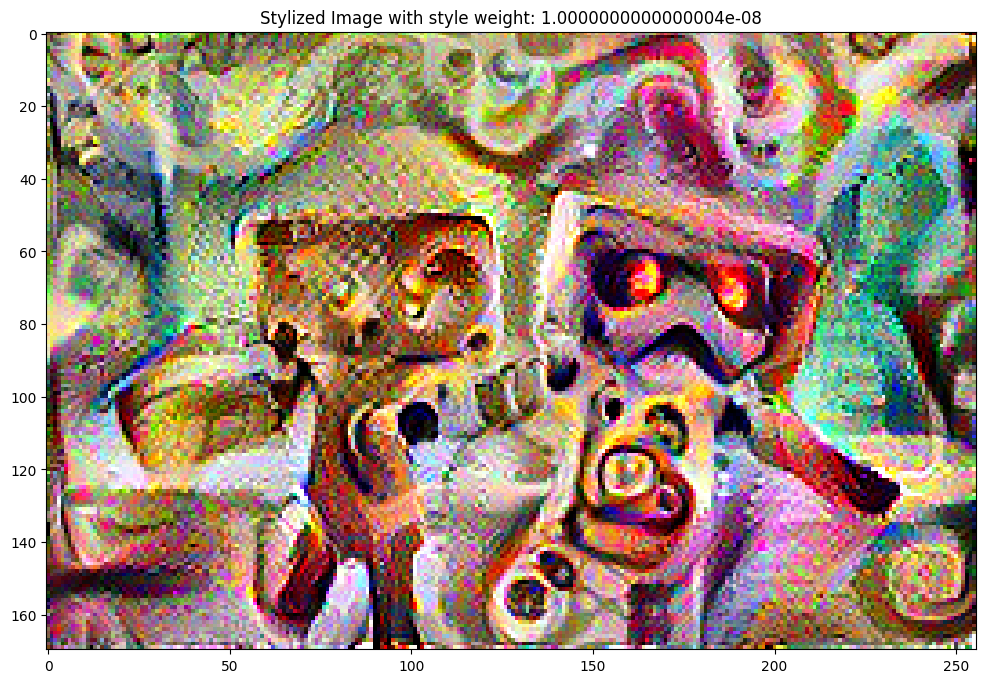

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# [Your existing code for loading images, defining the model, etc., goes here]

# Define weights for style and content loss
content_weight = 1e4

# Function to perform optimization and display the image
def run_style_transfer_and_display(style_weight):
    # Update style weight
    global style_targets, content_targets, image, extractor

    # Reset the image to the original content image at the start of each run
    image.assign(tf.Variable(content_image))

    # Optimization loop
    epochs = 10
    steps_per_epoch = 100

    for n in range(epochs):
        for m in range(steps_per_epoch):
            train_step(image)

    # Display the stylized image
    plt.figure(figsize=(12, 12))
    imshow(image.read_value(), f'Stylized Image with style weight: {style_weight}')
    plt.show()

# Run the style transfer for various style weights
for _ in np.arange(5):  # Adjust this range as needed
    style_weight=style_weight*0.1
    run_style_transfer_and_display(style_weight)
